# Full Walk Through

There are mainly two methods for using Herbie

1. When working with *one* file at a time, you should use the `Herbie` class imported from `herbie.archive` to create Herbie objects.
1. When working with *many* files at a time across different dates and forecast lead times, there are some helper functions in `herbie.tools`.

> [**More examples**](https://blaylockbk.github.io/Herbie/_build/html/user_guide/notebooks/index.html)

## Creating a Herbie Object
The `Herbie` class gives you the details about an single GRIB2 file with methods to download the file, open with xarray, and subset the file by variable.

What does this class do? When you specify a datetime, model type, and forecast lead time, Herbie will search the different archive sources for the file you are requesting. By default, it searches for the HRRR model (`model='hrrr'`) surface fields (`product='sfc'`) for the zero-hour lead time (`fxx=0'`).

In [2]:
from herbie import Herbie

In [3]:
help(Herbie)

Help on class Herbie in module herbie.archive:

class Herbie(builtins.object)
 |  Herbie(date=None, *, valid_date=None, model='hrrr', fxx=0, product=None, priority=None, save_dir=WindowsPath('C:/Users/blaylock/data'), overwrite=False, verbose=True, **kwargs)
 |  
 |  Locate GRIB2 file at one of the archive sources.
 |  
 |  Parameters
 |  ----------
 |  date : pandas-parsable datetime
 |      *Model initialization datetime*.
 |      If None, then must set ``valid_date``.
 |  valid_date : pandas-parsable datetime
 |      Model valid datetime. Must set when ``date`` is None.
 |  fxx : int
 |      Forecast lead time in hours. Available lead times depend on
 |      the model type and model version. Range is model and run
 |      dependant.
 |  model : {'hrrr', 'hrrrak', 'rap', 'gfs', 'gfs_wave', 'ecmwf', 'rrfs', etc.}
 |      Model name as defined in the models template folder. CASE INSENSITIVE
 |      Some examples:
 |      - ``'hrrr'`` HRRR contiguous United States model
 |      - ``'hrr

In [4]:
H = Herbie("2022-04-23 00:00")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Apr-23 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


The Herbie object tells us a file matching our request was found on Amazon Web Services (AWS).

We can display some of details from the Herbie object by printing it.

In [5]:
H

▌▌Herbie HRRR model sfc product initialized 2022-Apr-23 00:00 UTC F00 ┊ source=aws

In [6]:
print(H)

║HERBIE╠ HRRR:sfc


 Now lets look at the GRIB2 and index file URLs.

In [7]:
H.grib

'https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220423/conus/hrrr.t00z.wrfsfcf00.grib2'

In [8]:
H.idx

'https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220423/conus/hrrr.t00z.wrfsfcf00.grib2.idx'

Generally, you will only need to search for files using the default source priority order. But you can change the priority order if you wish.

In [9]:
# Specify the source priority to only look on Pando
H = Herbie("2022-01-05", priority="pando")

🤝🏻⛔ Bad handshake with pando? Am I able to move on?


SSLError: HTTPSConnectionPool(host='pando-rgw01.chpc.utah.edu', port=443): Max retries exceeded with url: /hrrr/sfc/20220105/hrrr.t00z.wrfsfcf00.grib2 (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:997)')))

In [ ]:
# Specify the source priority to only look on NOMADS
H = Herbie("2022-01-05", priority="nomads")

💔 Did not find ┊ model=hrrr ┊ product=sfc ┊ 2022-Jan-05 00:00 UTC F00


It doesn't look like the file was found on the NOMADS server (because NOMADS only stores the last 48 hours of HRRR data).

We can tell Herbie to look at AWS after looking at NOMADS

In [10]:
# Specify the source priority.
H = Herbie("2021-05-05", priority=["nomads", "aws"])

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-May-05 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


Ok, lets ask for the 15-hour forecast from our requested datetime

In [11]:
H = Herbie("2021-05-05", fxx=15)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-May-05 00:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws


We can also tell Herbie that the datetime we are requesting is the valid time. Herbie will adjust the model run time by the lead time requested.

In [12]:
H = Herbie(valid_date="2021-05-05", fxx=15)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-May-04 09:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws


### Download a Full File
If the file exists at one of the source locations, Herbie can download the full file to your local drive.

In [17]:
H = Herbie(valid_date="2021-05-05", fxx=15)
H.download(verbose=True)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-May-04 09:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\blaylock\data\hrrr\20210504]


KeyboardInterrupt: 

Since we downloaded the file, now when you ask Herbie for the file, it will tell you that the file is stored locally. (Since the index files are never downloaded, we still search the source locations for the index file).

In [13]:
H = Herbie(valid_date="2021-05-05", fxx=15)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-May-04 09:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws


### Download a Subset File
Often you don't need the full file, just a few variables. Because the index files tell us the byte range of each variable or GRIB message, we can download that portion of the file. Thus, files can be subsetted by variable. (Note that Herbie cannot subset the file by geographic area).

In this example, we will download all variables for the 1-h forecast for variables that are 2 m above ground.

In [14]:
# The full file already exists on Local Disk
H = Herbie(valid_date="2021-05-05", fxx=15)
H.download(":2 m", verbose=True)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-May-04 09:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\blaylock\data\hrrr\20210504]
📇 Download subset: ▌▌Herbie HRRR model sfc product initialized 2021-May-04 09:00 UTC F15 ┊ source=aws                                                            
 cURL from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20210504/conus/hrrr.t09z.wrfsfcf15.grib2
  58  :LTPINX:2 m above ground:15 hour fcst
  71  :TMP:2 m above ground:15 hour fcst
  72  :POT:2 m above ground:15 hour fcst
  73  :SPFH:2 m above ground:15 hour fcst
  74  :DPT:2 m above ground:15 hour fcst
  75  :RH:2 m above ground:15 hour fcst
💾 Saved the subset to C:\Users\blaylock\data\hrrr\20210504\subset_23b87d97__hrrr.t09z.wrfsfcf15.grib2


WindowsPath('C:/Users/blaylock/data/hrrr/20210504/subset_23b87d97__hrrr.t09z.wrfsfcf15.grib2')

If we ask to download this file again, Herbie tells us we already have a local copy. But we can overwrite if you need to.

In [15]:
# The Subset File Already Exists
H = Herbie(valid_date="2021-05-05", fxx=15)
H.download(":2 m", verbose=True, overwrite=True)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-May-04 09:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
📇 Download subset: ▌▌Herbie HRRR model sfc product initialized 2021-May-04 09:00 UTC F15 ┊ source=aws                                                            
 cURL from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20210504/conus/hrrr.t09z.wrfsfcf15.grib2
  58  :LTPINX:2 m above ground:15 hour fcst
  71  :TMP:2 m above ground:15 hour fcst
  72  :POT:2 m above ground:15 hour fcst
  73  :SPFH:2 m above ground:15 hour fcst
  74  :DPT:2 m above ground:15 hour fcst
  75  :RH:2 m above ground:15 hour fcst
💾 Saved the subset to C:\Users\blaylock\data\hrrr\20210504\subset_23b87d97__hrrr.t09z.wrfsfcf15.grib2


WindowsPath('C:/Users/blaylock/data/hrrr/20210504/subset_23b87d97__hrrr.t09z.wrfsfcf15.grib2')

In [ ]:
# Now download the full file with overwrite
H = Herbie(valid_date="2021-05-05", fxx=15, overwrite=True)
H.download()

🏋🏻‍♂️ Found 2021-May-04 09:00 UTC F15 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       


### Index files and Subset Search String

Each GRIB2 file should include a companion inventory or index file. The GRIB2 filename usually has the **.idx** suffix appended to the end of the filename. This file is important because it tells us the byte range of each variable GRIB message, which enables us to do a partial download of the file using cURL.

The magic trick for subsetting the data for what you want comes down to the search string. Herbie uses regular expression to search for lines in the index file to match which grib messages to download. Some examples are as follows.

 ``searchString``               |  Messages that will be downloaded
--------------------------------|-----------------------------------------------
 `":TMP:2 m"`                   | Temperature at 2 m.
 `":TMP:"`                      | Temperature fields at all levels.
 `":UGRD:.* mb"`                | U Wind at all pressure levels.
 `":500 mb:"`                   | All variables on the 500 mb level.
 `":APCP:"`                     | All accumulated precipitation fiel
 `":APCP:surface:0-[1-9]*"`     | Accumulated precip since initializ
 `":APCP:surface:[1-9]*-[1-9]*"`| Accumulated precip over last hour
 `":UGRD:10 m"`                 | U wind component at 10 meters.
 `":(?:U\|V)GRD:(?:10\|80) m"`  | U and V wind component at 10 and 8
 `":(?:U\|V)GRD:"`              | U and V wind component at all leve
 `":.GRD:"`                     | (Same as above)
 `":(?:TMP\|DPT):"`             | Temperature and Dew Point for all 
 `":(?:TMP\|DPT\|RH):"`         | TMP, DPT, and Relative Humidity fo
 `":REFC:"`                     | Composite Reflectivity
 `":surface:"`                  | All variables at the surface.

If you need help with regular expression, search the web
or look at this [cheatsheet](https://www.petefreitag.com/cheatsheets/regex/).

Herbie reads the index file into a Pandas Dataframe. The regular expression searches the "search_this" column to match rows in the index file.

In [16]:
H.read_idx()

,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1,0,636814,0-636814,2021-05-04 09:00:00,2021-05-05,REFC,entire atmosphere,15 hour fcst,:REFC:entire atmosphere:15 hour fcst
1,2,636814,962034,636814-962034,2021-05-04 09:00:00,2021-05-05,RETOP,cloud top,15 hour fcst,:RETOP:cloud top:15 hour fcst
2,3,962034,1603774,962034-1603774,2021-05-04 09:00:00,2021-05-05,var discipline=0 center=7 local_table=1 parmca...,entire atmosphere,15 hour fcst,:var discipline=0 center=7 local_table=1 parmc...
3,4,1603774,1910611,1603774-1910611,2021-05-04 09:00:00,2021-05-05,VIL,entire atmosphere,15 hour fcst,:VIL:entire atmosphere:15 hour fcst
4,5,1910611,3239678,1910611-3239678,2021-05-04 09:00:00,2021-05-05,VIS,surface,15 hour fcst,:VIS:surface:15 hour fcst
...,...,...,...,...,...,...,...,...,...,...
168,169,151936733,151937231,151936733-151937231,2021-05-04 09:00:00,2021-05-05,ICEC,surface,15 hour fcst,:ICEC:surface:15 hour fcst
169,170,151937231,153642912,151937231-153642912,2021-05-04 09:00:00,2021-05-05,SBT123,top of atmosphere,15 hour fcst,:SBT123:top of atmosphere:15 hour fcst
170,171,153642912,155314328,153642912-155314328,2021-05-04 09:00:00,2021-05-05,SBT124,top of atmosphere,15 hour fcst,:SBT124:top of atmosphere:15 hour fcst
171,172,155314328,156883538,155314328-156883538,2021-05-04 09:00:00,2021-05-05,SBT113,top of atmosphere,15 hour fcst,:SBT113:top of atmosphere:15 hour fcst


In [17]:
# See what messages will be downloaded by a search string.
H.read_idx("(?:U|V)GRD:(?:10|80) m")

,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
59,60,36906392,38106734,36906392-38106734,2021-05-04 09:00:00,2021-05-05,UGRD,80 m above ground,15 hour fcst,:UGRD:80 m above ground:15 hour fcst
60,61,38106734,39269979,38106734-39269979,2021-05-04 09:00:00,2021-05-05,VGRD,80 m above ground,15 hour fcst,:VGRD:80 m above ground:15 hour fcst
76,77,52662153,55043768,52662153-55043768,2021-05-04 09:00:00,2021-05-05,UGRD,10 m above ground,15 hour fcst,:UGRD:10 m above ground:15 hour fcst
77,78,55043768,57425383,55043768-57425383,2021-05-04 09:00:00,2021-05-05,VGRD,10 m above ground,15 hour fcst,:VGRD:10 m above ground:15 hour fcst


In [22]:
# See what messages will be downloaded by a search string.
H.read_idx("(U|V)GRD:[8|5][0|5]0 mb")

C:\Users\blayl_depgywe\BB_python\Herbie\herbie\archive.py:634: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
16,17,11102539,11718442,11102539-11718442,2021-05-04 09:00:00,2021-05-05,UGRD,500 mb,15 hour fcst,:UGRD:500 mb:15 hour fcst
17,18,11718442,12320354,11718442-12320354,2021-05-04 09:00:00,2021-05-05,VGRD,500 mb,15 hour fcst,:VGRD:500 mb:15 hour fcst
27,28,19477225,20120596,19477225-20120596,2021-05-04 09:00:00,2021-05-05,UGRD,850 mb,15 hour fcst,:UGRD:850 mb:15 hour fcst
28,29,20120596,20748701,20120596-20748701,2021-05-04 09:00:00,2021-05-05,VGRD,850 mb,15 hour fcst,:VGRD:850 mb:15 hour fcst


Here's another example: download all variables at 500 mb

In [18]:
# Download a different Subset of File the local file
H = Herbie(valid_date="2022-03-05 12:00", fxx=0)
H.download(":500 mb:", verbose=True)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Mar-05 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\blaylock\data\hrrr\20220305]
📇 Download subset: ▌▌Herbie HRRR model sfc product initialized 2022-Mar-05 12:00 UTC F00 ┊ source=aws                                                            
 cURL from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220305/conus/hrrr.t12z.wrfsfcf00.grib2
  14  :HGT:500 mb:anl
  15  :TMP:500 mb:anl
  16  :DPT:500 mb:anl
  17  :UGRD:500 mb:anl
  18  :VGRD:500 mb:anl
💾 Saved the subset to C:\Users\blaylock\data\hrrr\20220305\subset_c5efbe61__hrrr.t12z.wrfsfcf00.grib2


WindowsPath('C:/Users/blaylock/data/hrrr/20220305/subset_c5efbe61__hrrr.t12z.wrfsfcf00.grib2')

Herbie creates a unique filename for the subsetted files when it is downloaded.

In [19]:
# Show path to subset file. You should check if this path exists or not.
H.get_localFilePath(":500 mb")

WindowsPath('C:/Users/blaylock/data/hrrr/20220305/subset_c5efbe61__hrrr.t12z.wrfsfcf00.grib2')

### Read GRIB2 file with xarray
Herbie can read GRIB2 files with xarray via cfgrib. By default, if the file requested does not already exist on local disk, Herbie will delete the file after it is loaded into memory (if on Linux; removing file does not work on Windows.). 

In [20]:
# Read file with xarray that does not exists on disk
H = Herbie("2022-04-02 06:00", fxx=0)
Hx = H.xarray(":500 mb", verbose=True)
Hx

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Apr-02 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\blaylock\data\hrrr\20220402]
📇 Download subset: ▌▌Herbie HRRR model sfc product initialized 2022-Apr-02 06:00 UTC F00 ┊ source=aws                                                            
 cURL from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220402/conus/hrrr.t06z.wrfsfcf00.grib2
  14  :HGT:500 mb:anl
  15  :TMP:500 mb:anl
  16  :DPT:500 mb:anl
  17  :UGRD:500 mb:anl
  18  :VGRD:500 mb:anl
💾 Saved the subset to C:\Users\blaylock\data\hrrr\20220402\subset_6fefbe61__hrrr.t06z.wrfsfcf00.grib2


C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")


<xarray.Dataset>
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2022-04-02T06:00:00
    step                 timedelta64[ns] 00:00:00
    isobaricInhPa        float64 500.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2022-04-02T06:00:00
Dimensions without coordinates: y, x
Data variables:
    t                    (y, x) float32 267.3 267.3 267.3 ... 250.7 250.8 250.8
    u                    (y, x) float32 6.373 6.373 6.373 ... -2.002 -1.94 -1.94
    v                    (y, x) float32 -4.079 -4.079 -4.079 ... 18.8 19.17
    gh                   (y, x) float32 5.853e+03 5.853e+03 ... 5.308e+03
    dpt                  (y, x) float32 244.5 244.4 244.2 ... 229.5 229.4 229.2
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              C:\Users\blaylock\data\hrrr\20220402\subset_6fef...
    searchString:            :500 mb

In [21]:
# Notice that the local grib subset file does not exists locally because it was removed
Hx.attrs["local_grib"].exists()

True

In [27]:
# You can tell xarray not to delete the grib2 file
H = Herbie("2021-05-06", fxx=0)
Hx = H.xarray(":500 mb", remove_grib=False)
Hx

🏋🏻‍♂️ Found 2021-May-06 00:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
👨🏻‍🏭 Created directory: [C:\Users\blayl_depgywe\data\hrrr\20210506]


<xarray.Dataset>
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2021-05-06
    step                 timedelta64[ns] 00:00:00
    isobaricInhPa        float64 500.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2021-05-06
Dimensions without coordinates: y, x
Data variables:
    t                    (y, x) float32 ...
    u                    (y, x) float32 ...
    v                    (y, x) float32 ...
    gh                   (y, x) float32 ...
    dpt                  (y, x) float32 ...
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              C:\Users\blayl_depgywe\data\hrrr\20210506\hrrr.t...
    searchString:            :500 mb

In [31]:
# The local grib does exists
Hx.attrs["local_grib"].exists()

True

## Working with multiple Herbie objects
Use the **fast Herbie** functions when you want to work with multiple files at once. Fast Herbie uses multithreading to increase the speed of sequentially creating Herbie objects. 

Creating a Herbie object is a lot of network traffic (Herbie check if a GRIB2 file exits at a lot of different remote archives and also looks for index files). Herbie also downloads the GRIB2 files, which is also mainly done over the network, and reading the data into xarray depends on the downloads.

Multithreading is useful for I/O bound tasks. As I understand, communication across the internet falls under this category. So multi threads can be helpful when creating many Herbie objects.

- Creating lots of Herbie objects
- Downloading lots of files
- Loading lots of files into xarray


In [22]:
from herbie import FastHerbie
import pandas as pd

In [23]:
# Use pandas to create a list of Datetimes
DATES = pd.date_range("2022-01-01", periods=3, freq="1H")

# Create a list of forecast lead times
fxx = [0, 1, 2]

### Fast Herbie
Create many Herbie objects for all the dates and lead times requested.

In [24]:
# Create many Herbie objects (for all dates and lead times requested)
HH = FastHerbie(DATES=DATES, fxx=fxx)
len(HH), HH

(9, <herbie.tools.FastHerbie at 0x1f7915f74f0>)

### Fast Herbie Download
Download the files for a subset of many Herbie objects

In [27]:
# Download those Herbie objects (subset by 2-m temperature)
a = HH.download(searchString="TMP:2 m")
a

👨🏻‍🏭 Created directory: [C:\Users\blaylock\data\hrrr\20220101]


[WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_04effd54__hrrr.t00z.wrfsfcf00.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_5ae4fd54__hrrr.t01z.wrfsfcf01.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_5aeffd54__hrrr.t01z.wrfsfcf00.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_0421fd54__hrrr.t00z.wrfsfcf02.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_04e4fd54__hrrr.t00z.wrfsfcf01.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_5a21fd54__hrrr.t01z.wrfsfcf02.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_72effd54__hrrr.t02z.wrfsfcf00.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_7221fd54__hrrr.t02z.wrfsfcf02.grib2'),
 WindowsPath('C:/Users/blaylock/data/hrrr/20220101/subset_72e4fd54__hrrr.t02z.wrfsfcf01.grib2')]

### Fast Herbie xarray
Read the data into an xarray DataFrame. Notice that this concatenates all the files along the datetime (t) and lead time (f) dimensions. 

> NOTE: The searchString ***must*** return data on the same hyper cube (data must be on the same type of level; see cfgrib for more details). For instance, you shouldn't load 2-m and 500 hPa data in the same object. 

> WARNING: Could run into memory limit if requesting too much data.

In [28]:
# Read into xarray
ds = HH.xarray(searchString="(?:U|V)GRD:10 m")
ds

C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")
C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")
C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")
C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")
C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")
C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I could

<xarray.Dataset>
Dimensions:              (time: 3, step: 3, y: 1059, x: 1799)
Coordinates:
  * time                 (time) datetime64[ns] 2022-01-01 ... 2022-01-01T02:0...
  * step                 (step) timedelta64[ns] 00:00:00 01:00:00 02:00:00
    heightAboveGround    float64 10.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           (step, time) datetime64[ns] 2022-01-01 ... 2022-01-0...
Dimensions without coordinates: y, x
Data variables:
    u10                  (step, time, y, x) float32 -3.392 -3.33 ... -0.05518
    v10                  (step, time, y, x) float32 -5.777 -5.777 ... 2.09 1.965
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    searchString:            (?:U|V)GRD:10 m

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

> # 🏗️ Under Construction

## Plot with `herbie` xarray custom accessor

This requires my [Carpenter Workshop](https://github.com/blaylockbk/Carpenter_Workshop) functions.

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\blaylock\data\hrrr\20221209]


C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")


cfgrib variable: t2m
GRIB_cfName air_temperature
GRIB_cfVarName t2m
GRIB_name 2 metre temperature
GRIB_units K
GRIB_typeOfLevel heightAboveGround



c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "t2m".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


<GeoAxesSubplot: title={'left': 'Run: 00:00 UTC 09 Dec 2022 F00', 'center': 'HRRR 2 m\n', 'right': 'Valid: 00:00 UTC 09 Dec 2022'}>

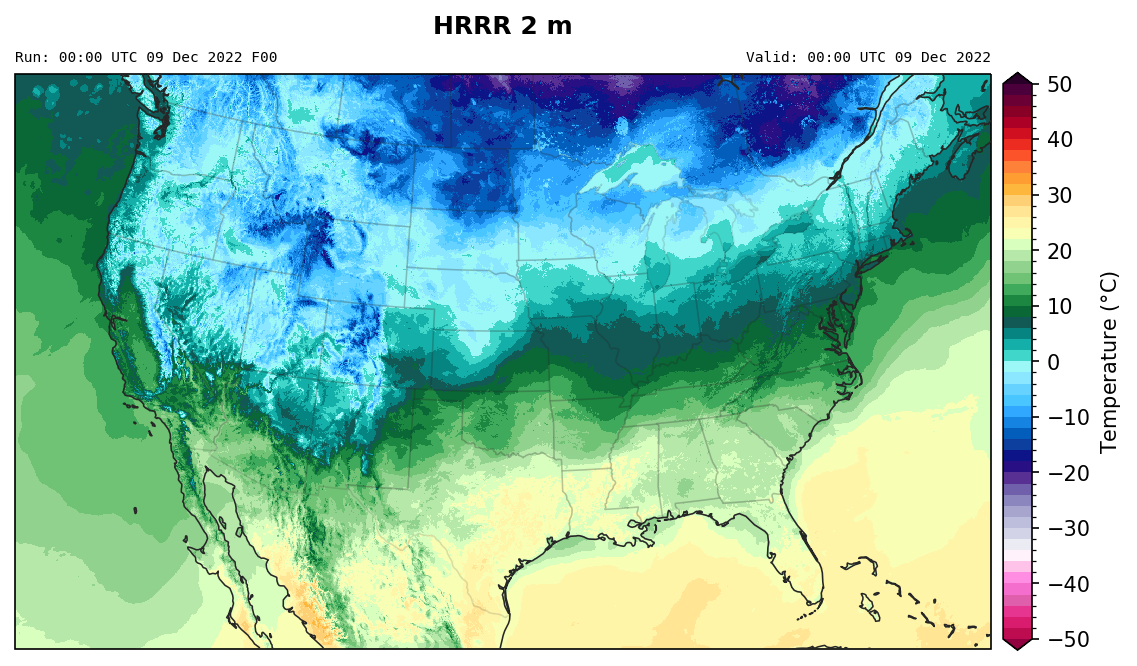

In [29]:
ds = Herbie('2022-12-09').xarray('TMP:2 m')
ds.herbie.plot()

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2022-Dec-09 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


C:\Users\blaylock\_GITHUB\Herbie\herbie\archive.py:1041: UserWarning: sorry, on windows I couldn't remove the file.
  warnings.warn("sorry, on windows I couldn't remove the file.")


cfgrib variable: u
GRIB_cfName eastward_wind
GRIB_cfVarName u
GRIB_name U component of wind
GRIB_units m s**-1
GRIB_typeOfLevel isobaricInhPa



c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "u".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "v".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


cfgrib variable: v
GRIB_cfName northward_wind
GRIB_cfVarName v
GRIB_name V component of wind
GRIB_units m s**-1
GRIB_typeOfLevel isobaricInhPa



c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "gribfile_projection".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
c:\Users\blaylock\Miniconda3\envs\herbie-dev\lib\site-packages\metpy\xarray.py:355: UserWarning: More than one time coordinate present for variable "u".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'


<GeoAxesSubplot: title={'left': 'Run: 00:00 UTC 09 Dec 2022 F00', 'center': 'HRRR 500 hPa\n', 'right': 'Valid: 00:00 UTC 09 Dec 2022'}>

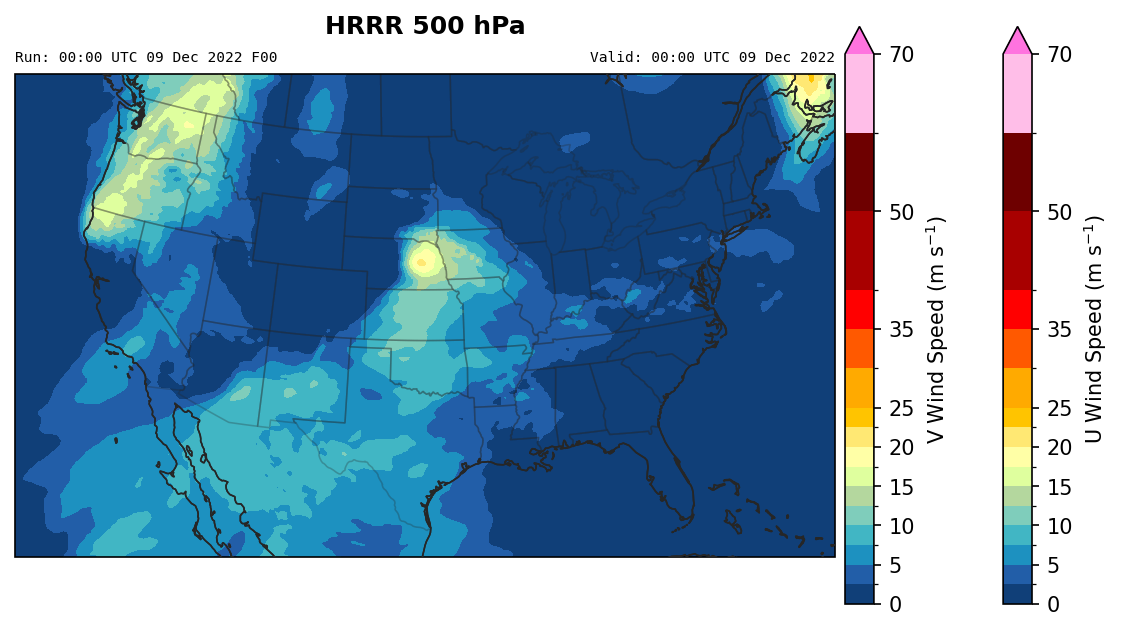

In [30]:
ds = Herbie('2022-12-09').xarray('GRD:500 mb')
ds.herbie.plot()

cfgrib variable: t
GRIB_cfName air_temperature
GRIB_cfVarName t
GRIB_name Temperature
GRIB_units K
GRIB_typeOfLevel isobaricInhPa



/p/home/blaylock/anaconda3/envs/basic38/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


cfgrib variable: u
GRIB_cfName eastward_wind
GRIB_cfVarName u
GRIB_name U component of wind
GRIB_units m s**-1
GRIB_typeOfLevel isobaricInhPa

cfgrib variable: v
GRIB_cfName northward_wind
GRIB_cfVarName v
GRIB_name V component of wind
GRIB_units m s**-1
GRIB_typeOfLevel isobaricInhPa

cfgrib variable: gh
GRIB_cfName geopotential_height
GRIB_cfVarName gh
GRIB_name Geopotential Height
GRIB_units gpm
GRIB_typeOfLevel isobaricInhPa

cfgrib variable: dpt
GRIB_cfName unknown
GRIB_cfVarName dpt
GRIB_name Dew point temperature
GRIB_units K
GRIB_typeOfLevel isobaricInhPa



<GeoAxesSubplot:title={'left':'Run: 00:00 UTC 06 May 2021 F00','center':'HRRR 500 hPa','right':'Valid: 00:00 UTC 06 May 2021'}>

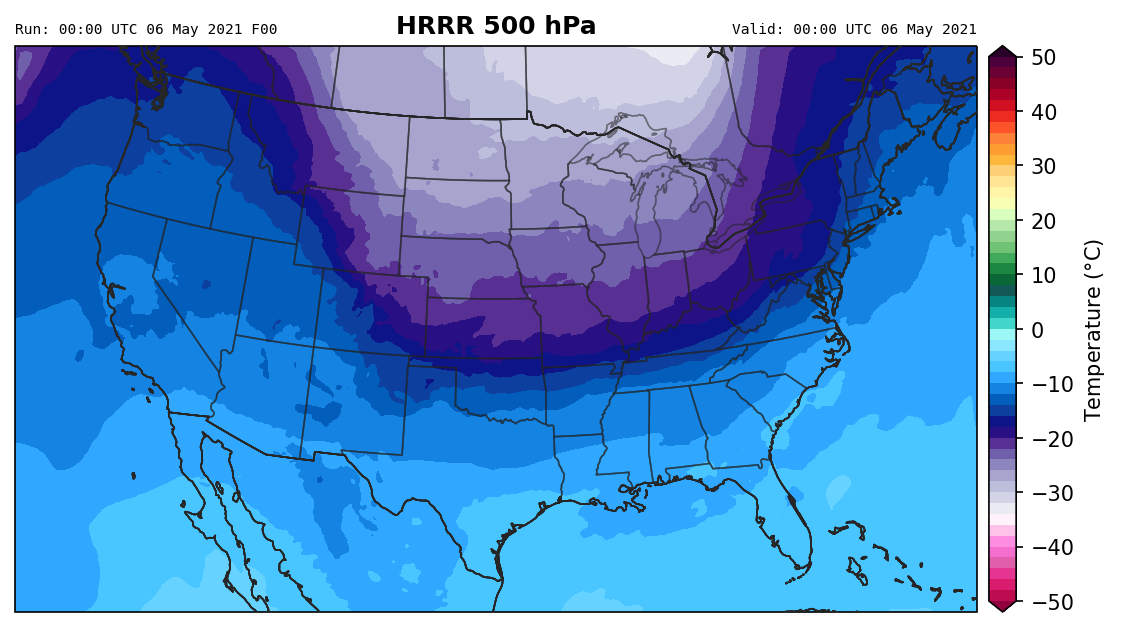

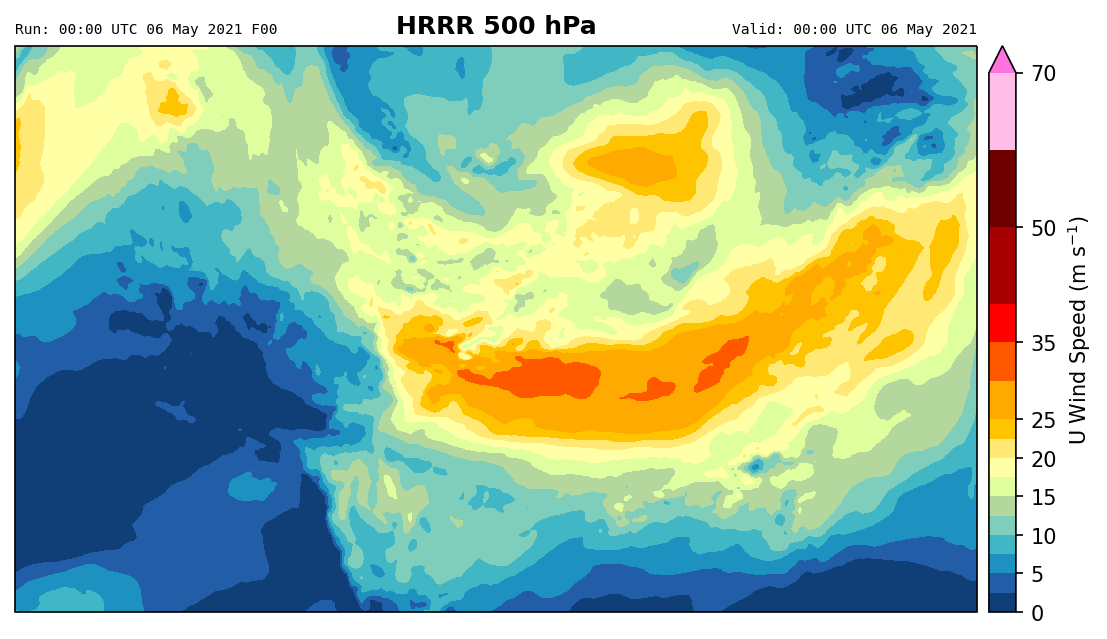

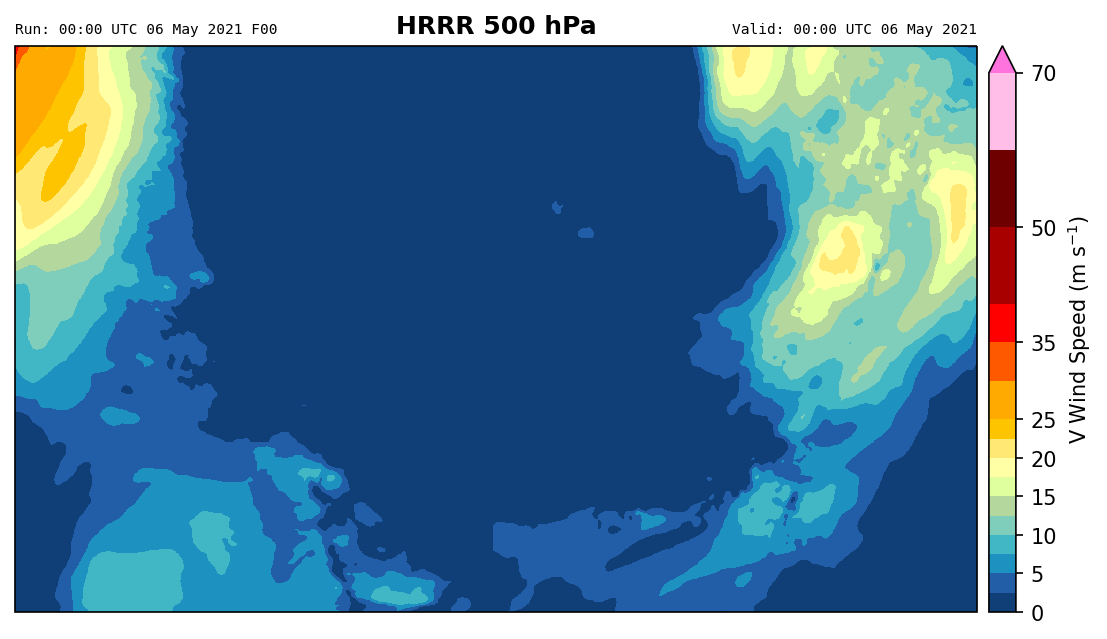

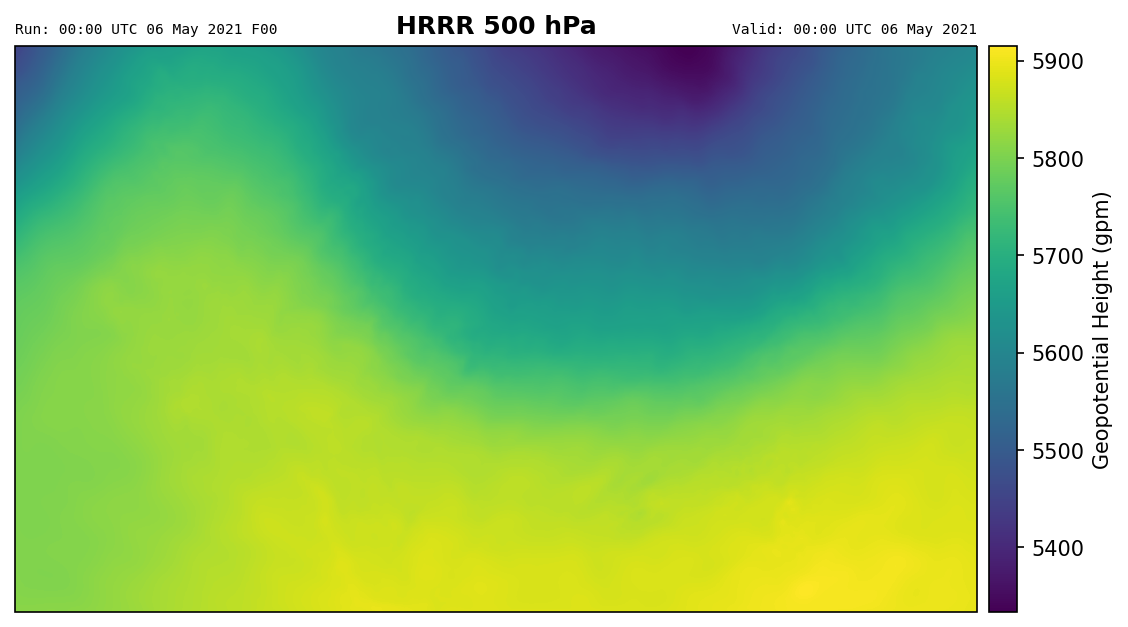

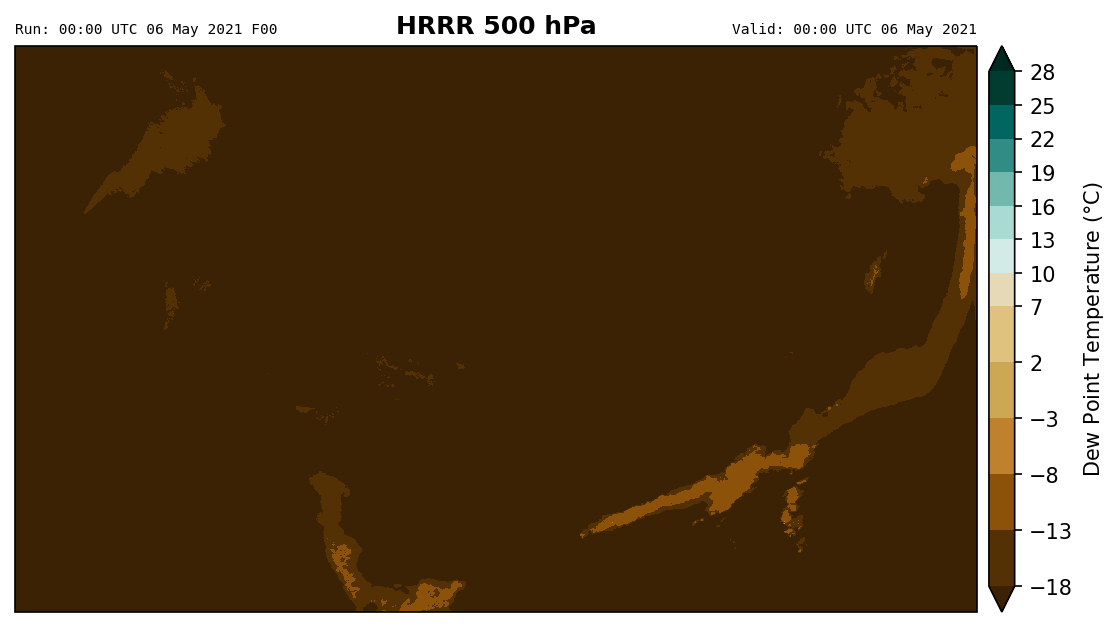

In [24]:
Hx.herbie.plot()